In [1]:
import torch
import torch.nn as nn
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchinfo import summary
from datetime import datetime
from helpers import *

if torch.cuda.is_available():
    print("Using GPU")
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    print("Using MPS")
    device = torch.device("mps")
else:
    print("Using CPU")
    device = torch.device("cpu")


Using GPU


# Hyperparameters

In [2]:
seq_size = 30 # number of previous days used to predict next day
test_start_date = pd.to_datetime("2023-01-01")
train_start_date = pd.to_datetime("2020-01-01")
out_cols = ['pct_change']
epochs = 25
batch_size = 256
d_model = 64 # number of input features to encoder layer
nhead = 8 # number of heads in multiheadattention
num_layers = 16 # number of encoder layers
dropout = 0.1 # dropout probability

In [3]:
# loading data
data_path = 'data'
interval = '1d'
companies = os.listdir(data_path)
# companies = ['AAPL']
for c in companies:
    if c == 'constituents.csv':
        companies.remove(c)
    elif c == '.DS_Store':
        companies.remove('.DS_Store')

# make unique number for each company ticker
ids = np.linspace(0, 1, len(companies)).round(5)
company_stats = dict() # keys are ticker, values are that company's stat dict
num_to_ticker = dict()
ticker_to_num = dict()
for i, num in enumerate(ids):
    num_to_ticker[str(num)] = companies[i]
    ticker_to_num[companies[i]] = num

df_list = []
stats_list = []
x_train = []
x_test = []
y_train = []
y_test = []
dates = []

for co in tqdm(companies):
    files = os.listdir(os.path.join(data_path, co))
    for f in files: # check each company folder for specific interval of data
        if interval in f:
            file = f

    df = pd.read_csv(os.path.join(data_path, co, file))
    df['date'] = pd.to_datetime(df['date'])
    # remove blank column
    df = df.drop(columns=['Unnamed: 0'])
    # remove data before training start date
    df = df[df['date'] >= train_start_date]

    # normalize columns, excluding date column
    df_normed, stat_dict = z_norm(df, 'date')
    # add ticker column
    df_normed['ticker'] = ticker_to_num[co]

    cols = list(df_normed.columns)
    cols.append(cols.pop(cols.index('date'))) # move date to end of list since this will be the order of columns for output df

    # split each df into train and test timeframes
    df_train = df_normed[df_normed['date'] < test_start_date]
    df_test = df_normed[df_normed['date'] >= test_start_date]

    pred_dates = df_test['date'].iloc[seq_size:].tolist()
    dates.append(pred_dates)

    # drop unnecessary columns
    df_train = df_train.drop(columns=['date'])
    df_test = df_test.drop(columns=['date'])

    # store column indices for extracting output features we want
    feature_cols_idx = [list(df_train.columns).index(feature) for feature in out_cols]

    # convert to 2D numpy arrays of shape (-1, num_cols)
    train = df_train.to_numpy()
    test = df_test.to_numpy()

    # convert to sequences and append to respective training and testing lists
    x, y = to_sequences(seq_size, train)
    for i in range(len(x)):
        x_train.append(x[i])
        y_train.append(y[i])
    x, y = to_sequences(seq_size, test)
    for i in range(len(x)):
        x_test.append(x[i])
        y_test.append(y[i])

    company_stats[co] = stat_dict
    stats_list.append(stat_dict)

indims = y_train[0].shape[0]
outdims = len(out_cols)
dates = [element for nestedlist in dates for element in nestedlist]

x_train = np.vstack(x_train).reshape(-1, seq_size, indims)
y_train = np.vstack(y_train).reshape(-1, indims)
x_test = np.vstack(x_test).reshape(-1, seq_size, indims)
y_test = np.vstack(y_test).reshape(-1, indims)

x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=6, pin_memory=True)

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=6, pin_memory=True)

  0%|          | 0/503 [00:00<?, ?it/s]

100%|██████████| 503/503 [00:24<00:00, 20.82it/s]


Using basic transformer from https://github.com/jeffheaton/app_deep_learning/blob/main/t81_558_class_10_3_transformer_timeseries.ipynb

In [4]:
# Positional Encoding for Transformer
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)
    
# Model definition using Transformer
class TransformerModel(nn.Module):
    def __init__(self, input_dim=1, output_dim=1, d_model=64, nhead=4, num_layers=2, dropout=0.1):
        super(TransformerModel, self).__init__()

        self.encoder = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.decoder = nn.Linear(d_model, output_dim)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1    
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, x):
        x = self.encoder(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = self.decoder(x[:, -1, :])
        return x

model = TransformerModel(input_dim=indims, output_dim=outdims, d_model=d_model, nhead=nhead, num_layers=num_layers, dropout=dropout).to(device)

In [5]:
# Train the model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5)

early_stop_count = 0
min_val_loss = float('inf')

for epoch in tqdm(range(epochs)):
    model.train()
    train_losses = []
    for batch in train_loader:
        x_batch, y_batch = batch
        y_batch = y_batch[:, feature_cols_idx]
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        train_losses.append(loss.item())
        optimizer.step()

    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in test_loader:
            x_batch, y_batch = batch
            y_batch = y_batch[:, feature_cols_idx]
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_losses.append(loss.item())

    val_loss = np.mean(val_losses)
    train_loss = np.mean(train_losses)
    scheduler.step(val_loss)

    # uncomment for early stopping
    # if val_loss < min_val_loss:
    #     min_val_loss = val_loss
    #     early_stop_count = 0
    # else:
    #     early_stop_count += 1

    # if early_stop_count >= 5:
    #     print("Early stopping!")
    #     break
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

  0%|          | 0/25 [00:00<?, ?it/s]c:\Users\oraga\anaconda3\envs\stocks\Lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
  4%|▍         | 1/25 [04:44<1:53:51, 284.65s/it]

Epoch 1/25, Train Loss: 1.1938, Validation Loss: 0.5407


  8%|▊         | 2/25 [09:20<1:47:01, 279.19s/it]

Epoch 2/25, Train Loss: 1.1867, Validation Loss: 0.5407


 12%|█▏        | 3/25 [13:42<1:39:35, 271.63s/it]

Epoch 3/25, Train Loss: 1.1862, Validation Loss: 0.5407


 16%|█▌        | 4/25 [18:00<1:33:12, 266.32s/it]

Epoch 4/25, Train Loss: 1.1860, Validation Loss: 0.5408


 20%|██        | 5/25 [22:18<1:27:47, 263.38s/it]

Epoch 5/25, Train Loss: 1.1859, Validation Loss: 0.5407


 24%|██▍       | 6/25 [48:11<3:42:14, 701.81s/it]

Epoch 6/25, Train Loss: 1.1858, Validation Loss: 0.5407


 28%|██▊       | 7/25 [52:30<2:47:05, 556.98s/it]

Epoch 7/25, Train Loss: 1.1857, Validation Loss: 0.5413


 32%|███▏      | 8/25 [56:49<2:10:53, 461.98s/it]

Epoch 8/25, Train Loss: 1.1856, Validation Loss: 0.5408


 36%|███▌      | 9/25 [1:07:36<2:18:37, 519.82s/it]

Epoch 9/25, Train Loss: 1.1856, Validation Loss: 0.5408


 40%|████      | 10/25 [1:11:55<1:49:48, 439.25s/it]

Epoch 10/25, Train Loss: 1.1856, Validation Loss: 0.5408


 44%|████▍     | 11/25 [1:16:13<1:29:35, 384.00s/it]

Epoch 11/25, Train Loss: 1.1856, Validation Loss: 0.5408


 48%|████▊     | 12/25 [1:20:32<1:14:56, 345.91s/it]

Epoch 12/25, Train Loss: 1.1856, Validation Loss: 0.5408


 52%|█████▏    | 13/25 [508:40:42<1845:04:58, 553524.83s/it]

Epoch 13/25, Train Loss: 1.1856, Validation Loss: 0.5409


 52%|█████▏    | 13/25 [508:43:35<469:35:37, 140878.10s/it] 


KeyboardInterrupt: 

In [ ]:
saved_weights_path = 'saved_models'
fn = f'AAPL_model_{datetime.now().strftime("%Y%m%d")}.pt'

In [ ]:
torch.save(model.state_dict(), os.path.join(saved_weights_path, fn))

# Testing

In [7]:
# testing with metrics
# model = TransformerModel(input_dim=indims, output_dim=outdims).to(device)
# model.load_state_dict(torch.load(os.path.join(saved_weights_path, "AAPL_model_20240209.pt")))
results = []
gt_preds = []
with torch.no_grad():
    for i, batch in tqdm(enumerate(test_loader)):
        x_batch, y_batch = batch
        tickers = [num_to_ticker[str(y_batch.detach().numpy()[idx,-1])] for idx in range(y_batch.shape[0])]
        y_batch = y_batch[:, feature_cols_idx]
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = model(x_batch)

        gt_outputs = process_results(y_batch, batch_size, i, dates, tickers)
        processed_outputs = process_results(outputs, batch_size, i, dates, tickers)

        [results.append(out) for out in processed_outputs]
        [gt_preds.append(out) for out in gt_outputs]

columns = [ele for nested in [out_cols, ['ticker', 'date']] for ele in nested]
df_pred = pd.DataFrame(results, columns=columns)
df_gt = pd.DataFrame(gt_preds, columns=columns)
for co in companies:
    df_pred[df_pred['ticker'] == co] = reverse_z_norm(df_pred, company_stats[co], col_exclude=['ticker', 'date'])
    df_gt[df_pred['ticker'] == co] = reverse_z_norm(df_gt, company_stats[co], col_exclude=['ticker', 'date'])

df_pred = rename_cols(df_pred, '_pred', ['date', 'ticker'])
df_gt = rename_cols(df_gt, '_gt', ['date', 'ticker'])
df_merged = pd.merge(df_pred, df_gt, 'inner')

0it [00:00, ?it/s]

886it [01:29,  9.91it/s]


In [8]:
df_merged.head()

,pct_change_pred,ticker,date,pct_change_gt
0,0.000344,A,2022-04-12,-0.044720
1,0.000234,A,2022-04-13,0.023128
2,0.000688,A,2022-04-14,-0.014420
3,0.000653,A,2022-04-18,-0.020563
4,0.000643,A,2022-04-19,0.021722


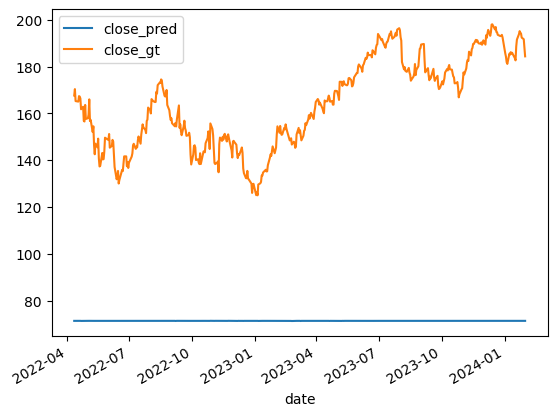

In [21]:
df_merged[df_merged['ticker'] == 'AAPL'].plot(x='date', y=['close_pred', 'close_gt'])
plt.legend()
plt.title(f"AAPL Close Prediction vs Ground Truth")
plt.show()

In [9]:
def directional_accuracy_pct_change(gt_pct, pred_pct):
    gt_sign = np.sign(np.asarray(gt_pct))
    pred_sign = np.sign(np.asarray(pred_pct))
    return np.sum(gt_sign == pred_sign) / len(gt_pct)

In [10]:
accuracy_metrics = dict()
for i in tqdm(range(len(companies))):
    gt_rows = df_merged[df_merged['ticker'] == companies[i]]['pct_change_gt']
    pred_rows = df_merged[df_merged['ticker'] == companies[i]]['pct_change_pred']
    accuracy_metrics[companies[i]] = directional_accuracy_pct_change(gt_rows, pred_rows)

 93%|█████████▎| 468/503 [00:16<00:01, 29.09it/s]C:\Users\oraga\AppData\Local\Temp\ipykernel_5548\627982602.py:5: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(gt_sign == pred_sign) / len(gt_pct)
100%|██████████| 503/503 [00:17<00:00, 29.04it/s]


In [11]:
accuracy_metrics

{'A': 0.4966887417218543,
 'AAL': 0.47019867549668876,
 'AAPL': 0.5143487858719646,
 'ABBV': 0.5275938189845475,
 'ABNB': 0.5011037527593819,
 'ABT': 0.4966887417218543,
 'ACGL': 0.5717439293598234,
 'ACN': 0.4988962472406181,
 'ADBE': 0.5077262693156733,
 'ADI': 0.4988962472406181,
 'ADM': 0.5055187637969095,
 'ADP': 0.5143487858719646,
 'ADSK': 0.5099337748344371,
 'AEE': 0.4922737306843267,
 'AEP': 0.5253863134657837,
 'AES': 0.46799116997792495,
 'AFL': 0.5474613686534217,
 'AIG': 0.5474613686534217,
 'AIZ': 0.543046357615894,
 'AJG': 0.543046357615894,
 'AKAM': 0.5298013245033113,
 'ALB': 0.4878587196467991,
 'ALGN': 0.47240618101545256,
 'ALL': 0.4966887417218543,
 'ALLE': 0.5033112582781457,
 'AMAT': 0.4988962472406181,
 'AMCR': 0.48123620309050774,
 'AMD': 0.4988962472406181,
 'AME': 0.5496688741721855,
 'AMGN': 0.48123620309050774,
 'AMP': 0.5077262693156733,
 'AMT': 0.47902869757174393,
 'AMZN': 0.5187637969094923,
 'ANET': 0.5364238410596026,
 'ANSS': 0.4966887417218543,
 'A

In [12]:
directional_accuracy_pct_change(df_merged['pct_change_gt'], df_merged['pct_change_pred'])


0.5105040440900687